In [22]:
import yaml
from scipy.ndimage import map_coordinates
import pickle
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column
import matplotlib as mpl
from astropy import constants, units
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scripts.plot_utils import *

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 20
path = '/Users/arcticfox/Documents/disks/models'
#parula = np.load('/Users/arcticfox/parula_colors.npy')

In [73]:
data_folders = ['twhydrae/baseline', 'twhydrae/l10', 'twhydrae/l100', 
                'twhydrae/l10_newhh', 'twhydrae/l100_newhh']
labels = ['L = L$_B = $0.54 L$_\odot$', 'L = 10L$_B$', 'L = 100L$_B$']
data_paths = [os.path.join(path, i) for i in data_folders]

tdust_ticks = np.linspace(10,1000,9)
tgas_ticks = np.logspace(1,np.log10(800), 10)
dgas_ticks = np.logspace(1,14,9)
p_ticks = 10**np.linspace(8,20,9)
ddust_ticks = np.logspace(-22,-14,9)
ylim=[0,3]

In [36]:
def make_subplots(data_paths, labels, transparent=False, xlim=[0,10], ylim=[0,1]):
    fig, axes = plt.subplots(ncols=4, nrows=len(data_paths), 
                             figsize=(8*len(data_paths), 6*len(data_paths)), sharex=True)
    
    if transparent==False:
        fig.set_facecolor('w')
    
    i = 0
    x = 0
    data = [open_interp(j) for j in data_paths]
    
    add_cbar, add_xlabel = True, False
    for ax in axes.reshape(-1):
        
        if i>3:
            add_cbar=False
        if i > 3+4*np.arange(0,len(data_paths),1)[-2]:
            add_xlabel=True
        
        if i in 0+4*np.arange(0,len(data_paths),1):
            plot_contour(data[x], 'RdYlBu_r', ticks=tdust_ticks, 
                         ax=ax, label='T$_{dust, lg}$ [K]',
                         index=3,ylim=ylim,add_cbar=add_cbar,
                         add_xlabel=add_xlabel, xlim=xlim)
            ax.set_ylabel('{}'.format(labels[x]),fontsize=26)
            
        if i in 1+4*np.arange(0,len(data_paths),1):
            plot_contour(data[x], 'RdYlBu_r', ticks=tgas_ticks, 
                         ax=ax, label='T$_{gas}$ [K]', 
                         skipticks=4,ylim=ylim,add_cbar=add_cbar,
                         add_xlabel=add_xlabel, xlim=xlim)
            
        if i in 2+4*np.arange(0,len(data_paths),1):
            plot_contour(data[x], 'viridis', ticks=p_ticks, 
                         ax=ax, label=r'$P_{gas}$ [J cm$^{-3}$]',
                         logNorm=True,ylim=ylim,pressure=True,
                         add_cbar=add_cbar, add_xlabel=add_xlabel, xlim=xlim)
        if i in 3+4*np.arange(0,len(data_paths),1):
            plot_contour(data[x], 'plasma', ticks=dgas_ticks, 
                         ax=ax, label=r'$\rho_{gas}$ [cm$^{-3}$]',
                         index=4, logNorm=True,ylim=ylim,
                         add_cbar=add_cbar, add_xlabel=add_xlabel, xlim=xlim)

        if i >= 3+4*np.arange(0,len(data_paths),1)[x]:
            x += 1
        i += 1
        
        ax.set_rasterized(True)
    #ax.set_xlim(0,300)
    return fig

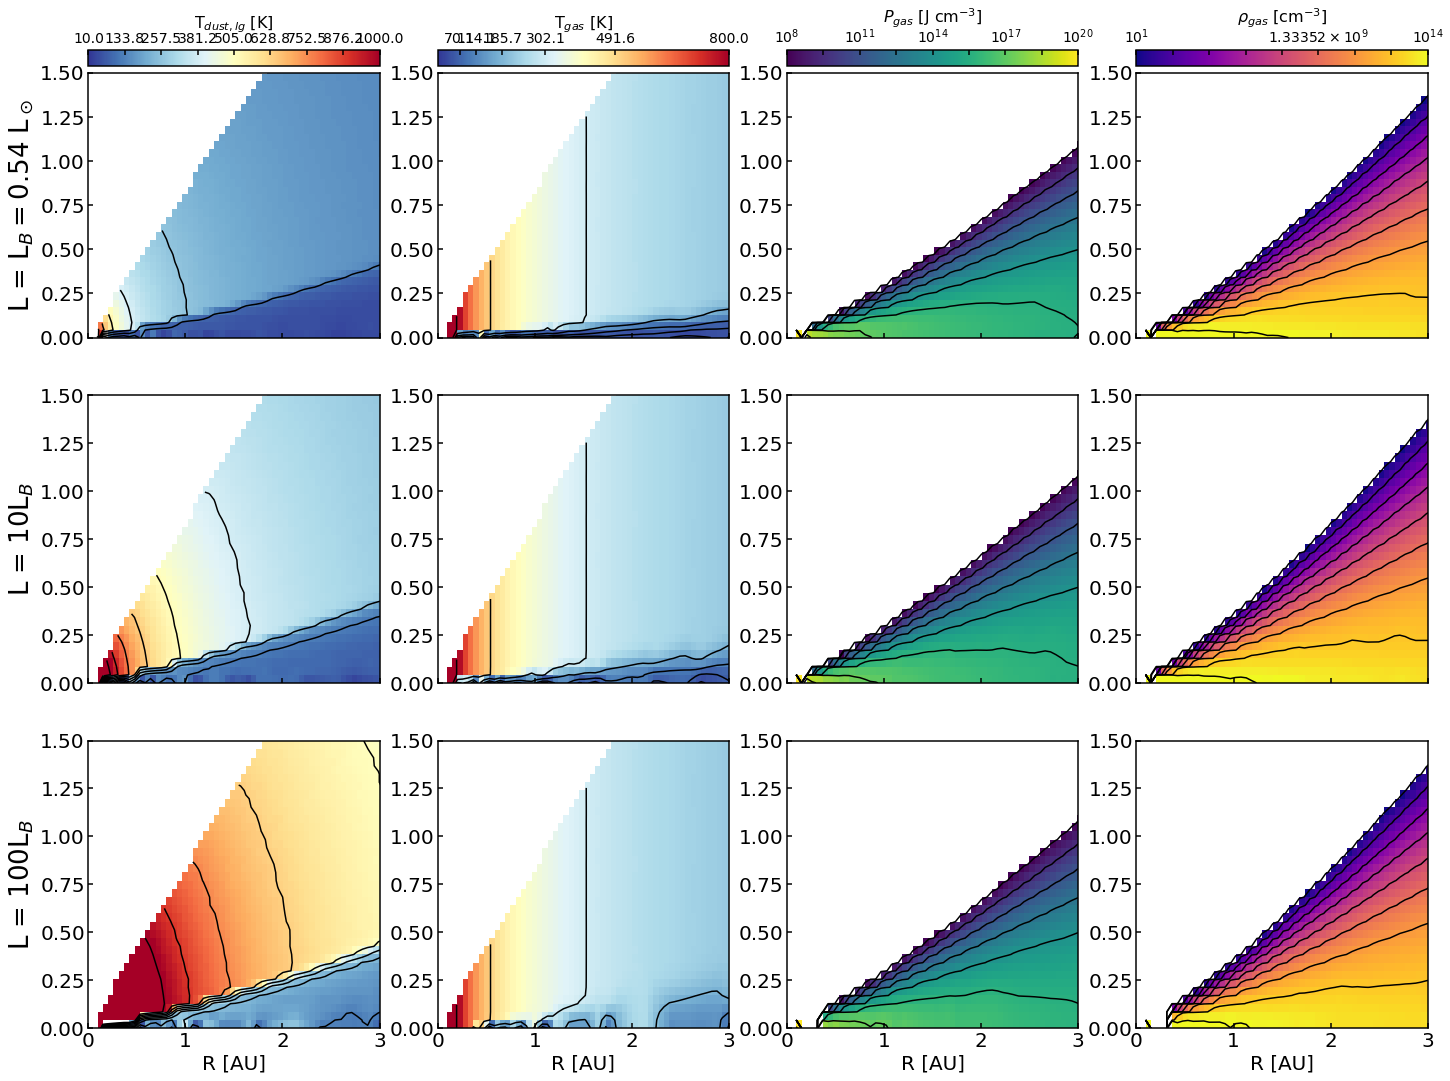

In [72]:
fig = make_subplots(data_paths, labels, xlim=[0,3], ylim=[0,1.5])

fig.savefig('/Users/arcticfox/Documents/disks/figures/twyhdrae_contours.png',
            rasterize=True, bbox_inches='tight', dpi=250)

In [40]:
output_labels = [r'$\rho_{dust, small}$ [cm$^{-3}$]',
                 r'$\rho_{dust, large}$ [cm$^{-3}$]',
                 'T$_{dust, small}$ [K]',
                 'T$_{dust, large}$ [K]',
                 r'$\rho_{gas}$ [cm$^{-3}$]',
                 'T$_{gas}$ [K]',
                 'P$_{gas}$ [J cm$^{-3}$]']

outputs = ['rhodustsm', 'rhodustlg', 'tdustsm', 'tdustlg', 'rhogas', 'tgas', 'pressure']
colors = ['deepskyblue', 'maroon', 'darkorange', 'xkcd:cornflower', 'gold']
tick_list = [0, 0, tdust_ticks, tdust_ticks, dgas_ticks, tgas_ticks, p_ticks]

##### ['rhodustsm', 'rhodustlg', 'tdustsm', 'tdustlg', 'rhogas', 'tgas', 'pressure']

In [41]:
def comp_line_plot(dp1, dp2, indices=[0, 1, 5, 2, 4, 6], zrs=[0,0.1,0.2,0.3,0.4],
                   colors=['deepskyblue', 'maroon', 'darkorange', 'xkcd:cornflower', 'gold'],
                   ylabel='% Difference', log=False):
    
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(21,10), 
                             sharex=True)
    ax = axes.reshape(-1)
    fig.set_facecolor('w')

    d1 = np.array(open_raw(dp1))
    d2 = np.array(open_raw(dp2))
    
    for i in range(len(ax)):
    
        if indices[i] != 6:
            rr1, zz1, dd1 = make_line_profiles(d1, indices[i], zrs=zrs)
            rr2, zz2, dd2 = make_line_profiles(d2, indices[i], zrs=zrs)
        else:
            p1 = pressure_profile(d1[4], d1[5], mu=2.3).value
            rr1, zz1, dd1 = make_line_profiles(d1, indices[i], p=p1, zrs=zrs)

            p2 = pressure_profile(d2[4], d2[5], mu=2.3).value
            rr2, zz2, dd2 = make_line_profiles(d2, indices[i], p=p2, zrs=zrs)

        ax[i].set_title(output_labels[indices[i]])

        for j in range(len(rr1)):
            
            if log == True and (indices[i] == 0 or indices[i] == 1):
                diff = (np.log10(dd2[j])-np.log10(dd1[j])) / np.log10(dd2[j]) * 100
                ax[i].set_ylim(-100,100)
            else:
                diff = (dd2[j]-dd1[j])/dd2[j]*100
                
                if indices[i] == 2 or indices[i] == 4:
                    ax[i].set_ylim(-50,100)
                else:
                    ax[i].set_ylim(-200,200)

            mask = (np.isnan(diff)==False) & (np.isfinite(diff)==True)
            if  i < 5:
                ax[i].plot(rr1[j][mask], diff[mask], c=colors[j], lw=6)
            else:
                ax[i].plot(rr1[j][mask], diff[mask], c=colors[j], lw=6,
                           label=zrs[j])

        if i == 5:
            leg = ax[i].legend(bbox_to_anchor=(1.05, 1), 
                               loc='upper left', borderaxespad=0.)
            leg.set_title('z/r')
        if i >= 3:
            ax[i].set_xlabel('R [AU]', fontsize=24)
        if i == 3:# or i ==0:
            ax[i].set_ylabel(ylabel, fontsize=24, y=1.1)

        ax[i].set_rasterized(True)
    return fig

In [42]:
data_paths

['/Users/arcticfox/Documents/disks/models/twhydrae/baseline',
 '/Users/arcticfox/Documents/disks/models/twhydrae/l10',
 '/Users/arcticfox/Documents/disks/models/twhydrae/l100']

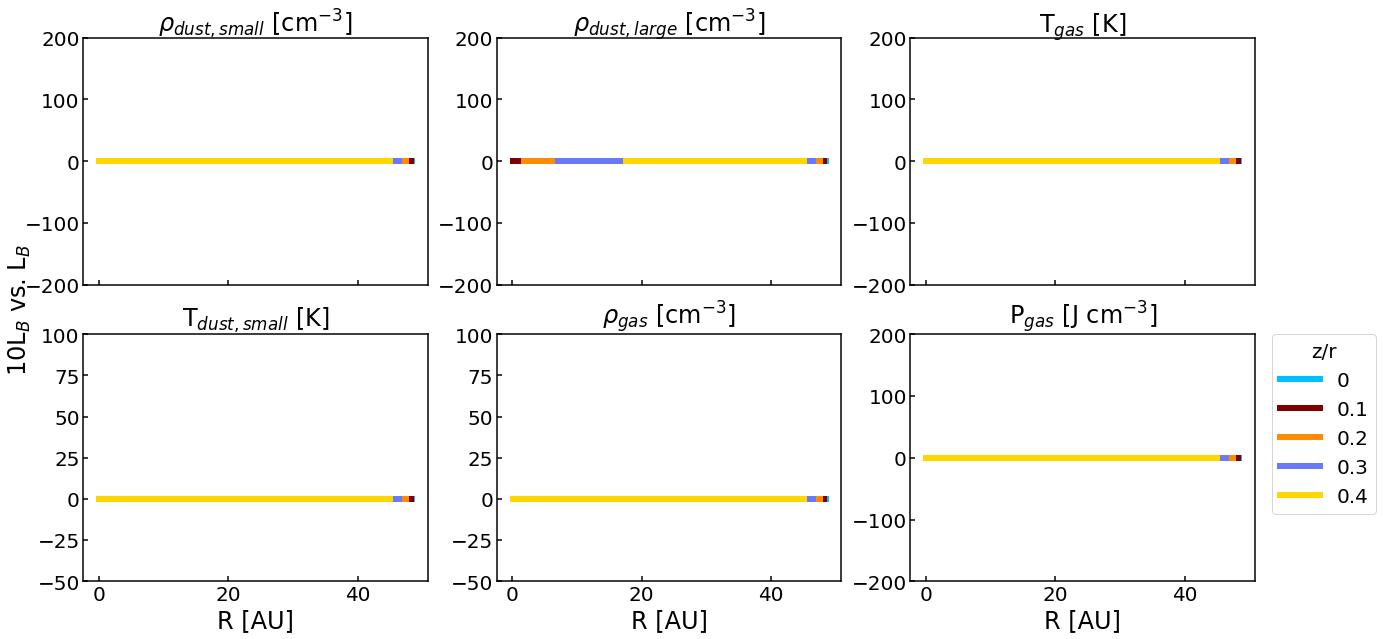

In [75]:
colors=['deepskyblue', 'maroon', 'darkorange', 'xkcd:cornflower', 'gold']
fig = comp_line_plot(data_paths[2], data_paths[4], ylabel='10L$_B$ vs. L$_B$')
#plt.savefig('/Users/arcticfox/Documents/disks/figures/twhydrae_comp10L.png',
#            rasterize=True, bbox_inches='tight', dpi=250)

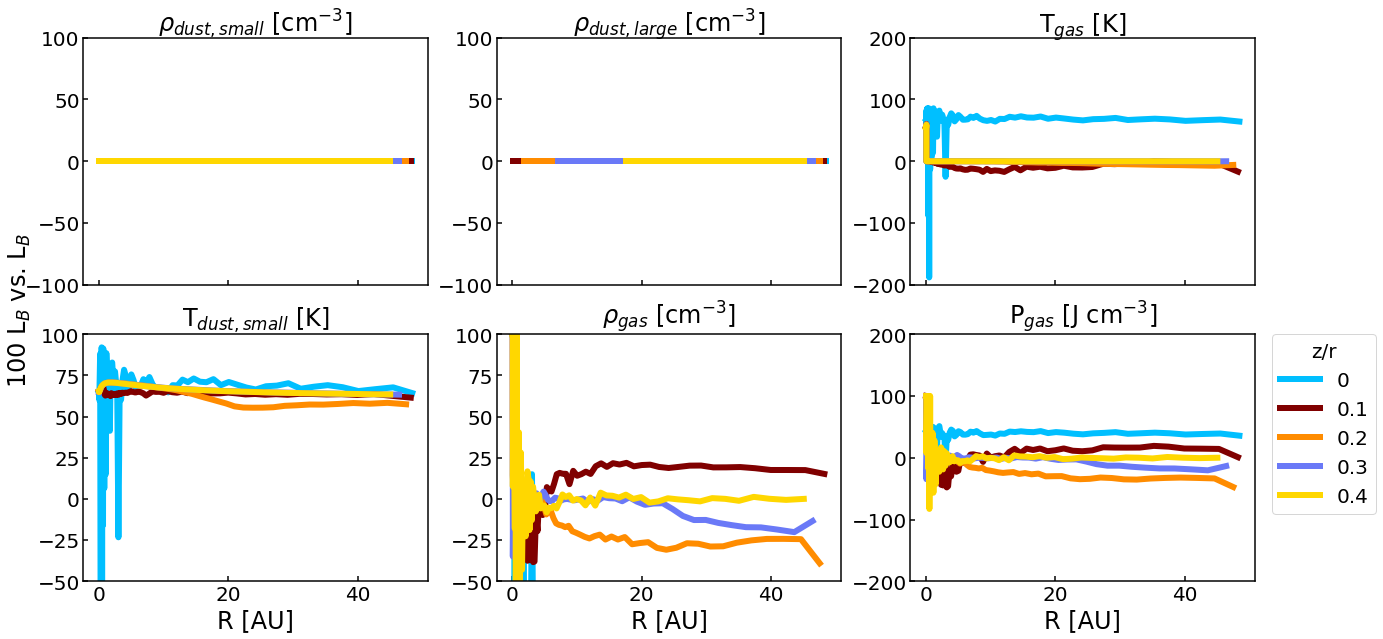

In [78]:
fig = comp_line_plot(data_paths[0], data_paths[2],  
                     ylabel='100 L$_B$ vs. L$_B$',
                     log=True)
plt.savefig('/Users/arcticfox/Documents/disks/figures/twhydrae_comp100L.png',
            rasterize=True, bbox_inches='tight', dpi=250)

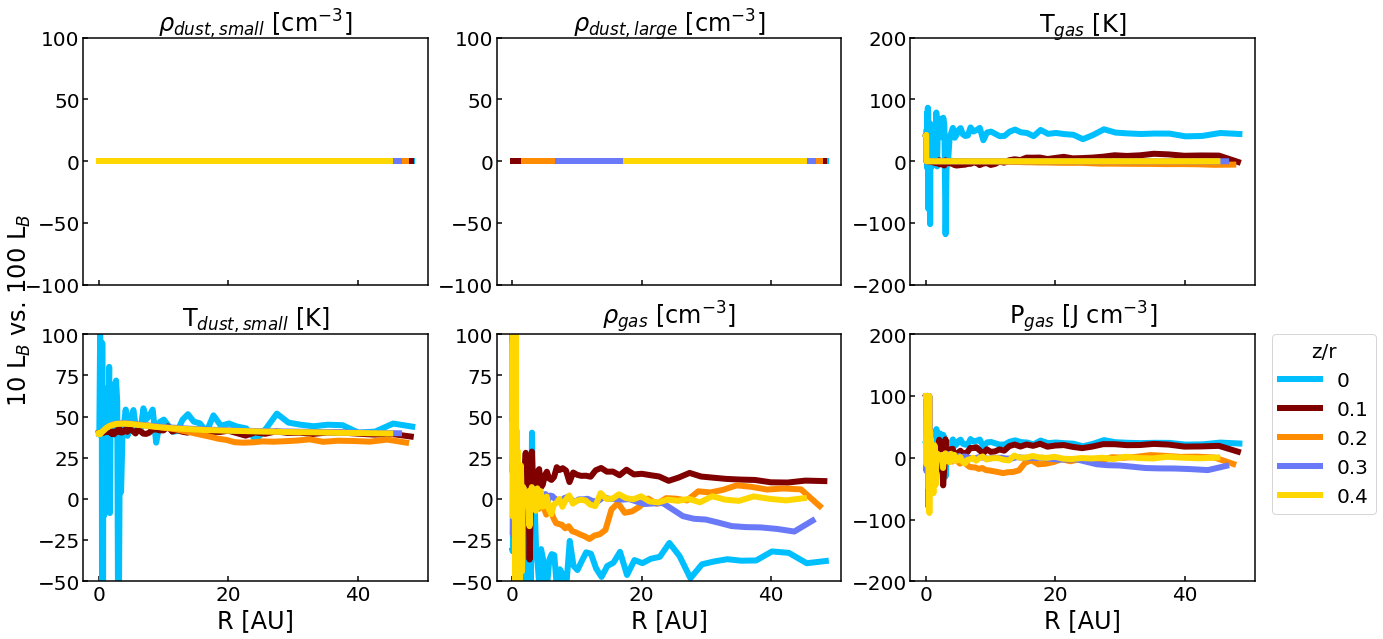

In [71]:
fig = comp_line_plot(data_paths[1], data_paths[2],  
                     ylabel='10 L$_B$ vs. 100 L$_B$',
                     log=True)
plt.savefig('/Users/arcticfox/Documents/disks/figures/twhydrae_comp_10L_100L.png',
            rasterize=True, bbox_inches='tight', dpi=250)

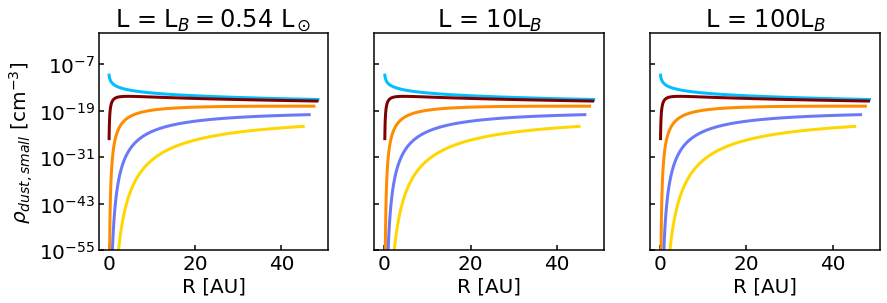

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14,4),
                                    sharex=True, sharey=True)
fig.set_facecolor('w')
for j, ax in enumerate([ax1,ax2,ax3]):
    d_tw = open_raw(data_paths[j])
    index = 0
    rrs, zzs, dds = make_line_profiles(d_tw, index)

    for i in range(len(rrs)):
        q = dds[i] > 0
        ax.plot(rrs[i][q], dds[i][q], c=colors[i], lw=3)
    if j == 0:
        ax.set_ylabel(output_labels[index])
    ax.set_title(labels[j])
    ax.set_xlabel('R [AU]')
    ax.set_yscale('log')
    ax.set_ylim(10**-55,10)
plt.savefig('/Users/arcticfox/Documents/disks/figures/twhydrae_comp_ddensity.png',
            rasterize=True, bbox_inches='tight', dpi=250)

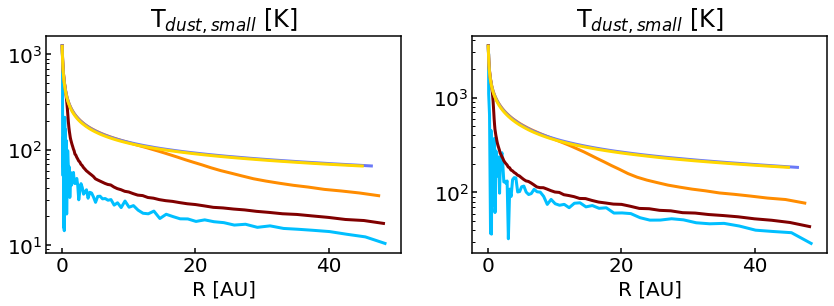

In [63]:
d_tw = open_raw(data_paths[0])
index = 2
rrs, zzs, dds = make_line_profiles(d_tw, index)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,4))

for i in range(len(rrs)):
    q = dds[i] > 0
    ax1.plot(rrs[i][q], dds[i][q], c=colors[i], lw=3)
ax1.set_title(output_labels[index])
ax1.set_xlabel('R [AU]')
ax1.set_yscale('log')


d_tw = open_raw(data_paths[2])
index = 2
rrs, zzs, dds = make_line_profiles(d_tw, index)

for i in range(len(rrs)):
    q = dds[i] > 0
    ax2.plot(rrs[i][q], dds[i][q], c=colors[i], lw=3)
ax2.set_title(output_labels[index])
ax2.set_xlabel('R [AU]')
ax2.set_yscale('log')
#fig = comp_line_plot(data_paths[-1], data_paths[-1],  ylabel='TW Hydrae Model', log=True)
#fig = comp_line_plot(data_paths[-1], data_paths[-1],  ylabel='TW Hydrae Model', log=True)

In [64]:
d_q = open_raw(data_paths[0])
d_o = open_raw(data_paths[1])
d_qi = open_interp(data_paths[1])
rr, zz, tm_q = make_line_profiles(d_q, index=2, zrs=[0])
rr, zz, tm_o = make_line_profiles(d_o, index=2, zrs=[0])

Text(0.5, 1.0, 'Herbig Disk Model')

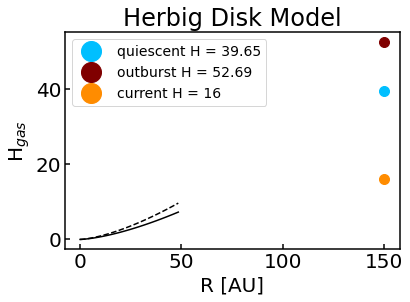

In [65]:
#rr = np.arange(0,200,1)

newh = scale_height(150, tm_q, 1.3).value
hout = scale_height(150, tm_o, 1.3).value
fig = plt.figure()
fig.set_facecolor('w')

plt.plot(rr[0], scale_height(rr[0], tm_q, 1.3).value, 'k')
plt.plot(rr[0], scale_height(rr[0], tm_o, 1.3).value, 'k--')

plt.plot(150, newh, 'o', 
         c=colors[0], ms=10, label='quiescent H = {}'.format(np.round(newh,2)))

plt.plot(150, hout, 'o', 
         c=colors[1], ms=10, label='outburst H = {}'.format(np.round(hout,2)))

plt.plot(150, 16, 'o', ms=10, label='current H = 16', c=colors[2])
plt.legend(fontsize=14)
plt.xlabel('R [AU]')
plt.ylabel('H$_{gas}$')
plt.title('Herbig Disk Model')
#plt.savefig('/Users/arcticfox/Documents/disks/figures/scale_height_comp_herbig.png',
#             rasterize=True, dpi=250, bbox_inches='tight')

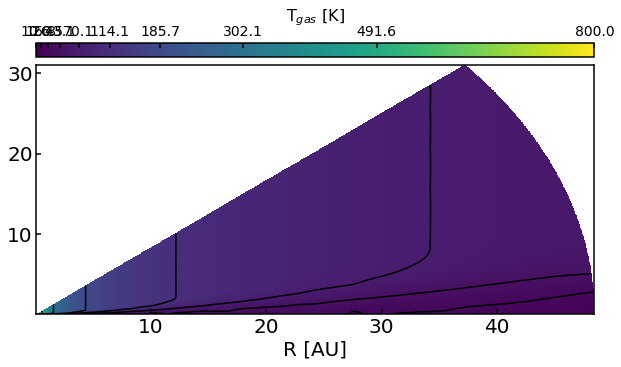

In [66]:
fig, ax = plt.subplots(figsize=(10,5))
plot_contour(d_qi, 'viridis', tgas_ticks, ax, 'T$_{gas}$ [K]', index=5)

In [ ]:
d_tw = open_raw(data_paths[-1])
rr, zz, tm_q = make_line_profiles(d_tw, index=2, zrs=zrs)

In [ ]:
rr = np.arange(0,200,1)

newh = scale_height(150, tm_q[0], 0.8).value
hout = scale_height(150, tm_o[0], 0.8).value

fig = plt.figure()
fig.set_facecolor('w')

plt.plot(rr, scale_height(rr, tm_q[0], 1.3).value, 'k')

plt.plot(150, scale_height(150, tm_q[0], 1.3).value, 'o', 
         c=colors[0], ms=10, label='quiescent H = {}'.format(np.round(newh,2)))

plt.plot(150, 15, 'o', ms=10, label='current H = 15', c=colors[2])
plt.legend(fontsize=14)
plt.xlabel('R [AU]')
plt.ylabel('H$_{gas}$')
plt.title('TW Hydrae Model')
#plt.savefig('/Users/arcticfox/Documents/disks/figures/scale_height_comp_twhyd.png',
#             rasterize=True, dpi=250, bbox_inches='tight')

## Writes the data tables

In [ ]:
tab = Table()
xx = -1
d = open_raw(data_paths[xx])
for i in range(len(d)-1):
    if i < 6:
        rr, zz, dd = make_line_profiles(d, index=i, zrs=zrs)
    else:
        p = pressure_profile(d[4], d[5],mu=2.3).value
        _, _, dd = make_line_profiles(d, 6, p=p, zrs=zrs)
        
    if i == 0:
        tab.add_column(Column(rr[0], 'R'))
        tab.add_column(Column(zz[0], 'Z'))
    for j in range(len(np.array(dd))):
        tab.add_column(Column(dd[j], '{}_zr_{}'.format(output[i], zrs[j])))
        
#tab.write('/Users/arcticfox/Documents/disks/{}.txt'.format(data_folders[xx]),
#          format='ascii')